# Поиск оптимальной архитектуры CNN

## Цель
Решить проблему в полносвязных слоях (8192→512 - сжатие в 16 раз)

## План
**Этап 0:** Baseline (1 эпоха) - Conv 32→512, FC 512→256  
**Этап 1:** FC варианты (2 эпохи) - тестируем 4 варианта FC слоев  
**Этап 2:** Топ-2 на 4 эпох + их Conv 2× варианты

## Параметры
- lr=1e-3, wd=1e-5, dropout=0.3 (фиксированный)
- Mushrooms_augmented_x7.pt (46,998 изображений)
- 2 эпохи на x7 ≈ 4,407 обновлений ≈ 15 эпох на preprocessed (3,150 обновлений)
- 4 эпох на x7 ≈ 14,690 обновлений ≈ 50 эпох на preprocessed (10,500 обновлений)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import pandas as pd
import random
import gc

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: mps


In [2]:
torch.manual_seed(42)
random.seed(42)

data = torch.load('../data/Mushrooms_augmented_x7.pt')
images = data['images']
labels = data['labels']
class_to_idx = data['class_to_idx']

print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')
print(f'Classes: {class_to_idx}')

Images shape: torch.Size([46998, 3, 128, 128])
Labels shape: torch.Size([46998])
Classes: {'Agaricus': 0, 'Amanita': 1, 'Boletus': 2, 'Cortinarius': 3, 'Entoloma': 4, 'Hygrocybe': 5, 'Lactarius': 6, 'Russula': 7, 'Suillus': 8}


In [3]:
dataset = TensorDataset(images, labels)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

g = torch.Generator()
g.manual_seed(42)

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=g)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=g)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Train size: {train_size}')
print(f'Test size: {test_size}')

Train size: 37598
Test size: 9400


## Модели

In [4]:
# Baseline: Conv 32→64→128→256→512, FC 512→256→9
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(BaselineCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(512 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        
        x = x.view(-1, 512 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [5]:
# FC_Wide: Conv 32→512, FC 1024→512→9
class FC_Wide(nn.Module):
    def __init__(self, num_classes=9):
        super(FC_Wide, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        
        x = x.view(-1, 512 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [6]:
# FC_Deep: Conv 32→512, FC 1024→512→256→9
class FC_Deep(nn.Module):
    def __init__(self, num_classes=9):
        super(FC_Deep, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, num_classes)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        
        x = x.view(-1, 512 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

In [7]:
# FC_DeepWide: Conv 32→512, FC 2048→1024→512→9
class FC_DeepWide(nn.Module):
    def __init__(self, num_classes=9):
        super(FC_DeepWide, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(512 * 4 * 4, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        
        x = x.view(-1, 512 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

## Этап 0: Baseline (2 эпохи)

Conv: 32→64→128→256→512  
FC: 8192→512→256→9  
lr=1e-3, wd=1e-5, dropout=0.3  
2 эпохи на augmented_x7 ≈ 15 эпох на preprocessed

In [8]:
model_baseline = BaselineCNN(num_classes=9).to(device)
criterion_baseline = nn.CrossEntropyLoss()
optimizer_baseline = optim.Adam(model_baseline.parameters(), lr=1e-3, weight_decay=1e-5)

num_epochs = 1
train_losses_baseline = []
train_accs_baseline = []
test_losses_baseline = []
test_accs_baseline = []

print('Обучение Baseline модели (1 эпоха на augmented_x7)\n')

for epoch in range(num_epochs):
    model_baseline.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer_baseline.zero_grad()
        outputs = model_baseline(images)
        loss = criterion_baseline(outputs, labels)
        loss.backward()
        optimizer_baseline.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    train_losses_baseline.append(epoch_loss)
    train_accs_baseline.append(epoch_acc)
    
    model_baseline.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_baseline(images)
            loss = criterion_baseline(outputs, labels)
            
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_loss = test_running_loss / len(test_loader)
    test_acc = 100 * test_correct / test_total
    test_losses_baseline.append(test_loss)
    test_accs_baseline.append(test_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

print(f'\nБазовая модель: Max Test Acc = {max(test_accs_baseline):.2f}% (Epoch {test_accs_baseline.index(max(test_accs_baseline))+1})')
print(f'Final Test Acc = {test_accs_baseline[-1]:.2f}%')

Обучение Baseline модели (2 эпохи на augmented_x7)

Epoch [1/1] Train Loss: 1.9255, Train Acc: 29.08%, Test Loss: 1.8382, Test Acc: 33.46%

Базовая модель: Max Test Acc = 33.46% (Epoch 1)
Final Test Acc = 33.46%


## Этап 1: FC варианты (2 эпохи)

Conv фиксирован: 32→512  
FC варианты:  
1. BaselineCNN: 512→256→9  
2. FC_Wide: 1024→512→9  
3. FC_Deep: 1024→512→256→9  
4. FC_DeepWide: 2048→1024→512→9  
  
2 эпохи на augmented_x7 ≈ 15 эпох на preprocessed

In [9]:
models_stage1 = [
    (BaselineCNN(num_classes=9).to(device), 'Baseline (512→256)'),
    (FC_Wide(num_classes=9).to(device), 'FC_Wide (1024→512)'),
    (FC_Deep(num_classes=9).to(device), 'FC_Deep (1024→512→256)'),
    (FC_DeepWide(num_classes=9).to(device), 'FC_DeepWide (2048→1024→512)')
]

results_stage1 = {}
num_epochs_stage1 = 2

for model, name in models_stage1:
    print(f'\nОбучение {name} (2 эпохи на augmented_x7)')
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    
    for epoch in range(num_epochs_stage1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        model.eval()
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        
        test_loss = test_running_loss / len(test_loader)
        test_acc = 100 * test_correct / test_total
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs_stage1}] Train Acc: {epoch_acc:.2f}%, Test Acc: {test_acc:.2f}%')
    
    results_stage1[name] = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'max_test_acc': max(test_accs),
        'max_test_epoch': test_accs.index(max(test_accs)) + 1,
        'final_test_acc': test_accs[-1],
        'final_train_acc': train_accs[-1]
    }
    
    print(f'Max Test Acc = {max(test_accs):.2f}% (Epoch {test_accs.index(max(test_accs))+1})')
    
    del model, criterion, optimizer
    gc.collect()
    if device.type == 'mps':
        torch.mps.empty_cache()


Обучение Baseline (512→256) (2 эпохи на augmented_x7)
Epoch [1/2] Train Acc: 28.03%, Test Acc: 32.61%
Epoch [2/2] Train Acc: 37.08%, Test Acc: 39.36%
Max Test Acc = 39.36% (Epoch 2)

Обучение FC_Wide (1024→512) (2 эпохи на augmented_x7)
Epoch [1/2] Train Acc: 27.99%, Test Acc: 32.47%
Epoch [2/2] Train Acc: 35.87%, Test Acc: 38.85%
Max Test Acc = 38.85% (Epoch 2)

Обучение FC_Deep (1024→512→256) (2 эпохи на augmented_x7)
Epoch [1/2] Train Acc: 26.78%, Test Acc: 33.36%
Epoch [2/2] Train Acc: 34.23%, Test Acc: 38.17%
Max Test Acc = 38.17% (Epoch 2)

Обучение FC_DeepWide (2048→1024→512) (2 эпохи на augmented_x7)
Epoch [1/2] Train Acc: 27.26%, Test Acc: 31.40%
Epoch [2/2] Train Acc: 34.07%, Test Acc: 37.50%
Max Test Acc = 37.50% (Epoch 2)


In [10]:
results_table_stage1 = []
for name, data in results_stage1.items():
    gap = data['final_train_acc'] - data['final_test_acc']
    results_table_stage1.append({
        'Модель': name,
        'Max Test Acc': data['max_test_acc'],
        'Epoch': data['max_test_epoch'],
        'Final Test Acc': data['final_test_acc'],
        'Gap': gap
    })

df_stage1 = pd.DataFrame(results_table_stage1)
df_stage1 = df_stage1.sort_values('Max Test Acc', ascending=False)
print('\n=== Результаты Этапа 1 (2 эпохи на augmented_x7) ===')
print(df_stage1.to_string(index=False))


=== Результаты Этапа 1 (2 эпохи на augmented_x7) ===
                     Модель  Max Test Acc  Epoch  Final Test Acc       Gap
         Baseline (512→256)     39.361702      2       39.361702 -2.279942
         FC_Wide (1024→512)     38.851064      2       38.851064 -2.979475
     FC_Deep (1024→512→256)     38.170213      2       38.170213 -3.944988
FC_DeepWide (2048→1024→512)     37.500000      2       37.500000 -3.431698


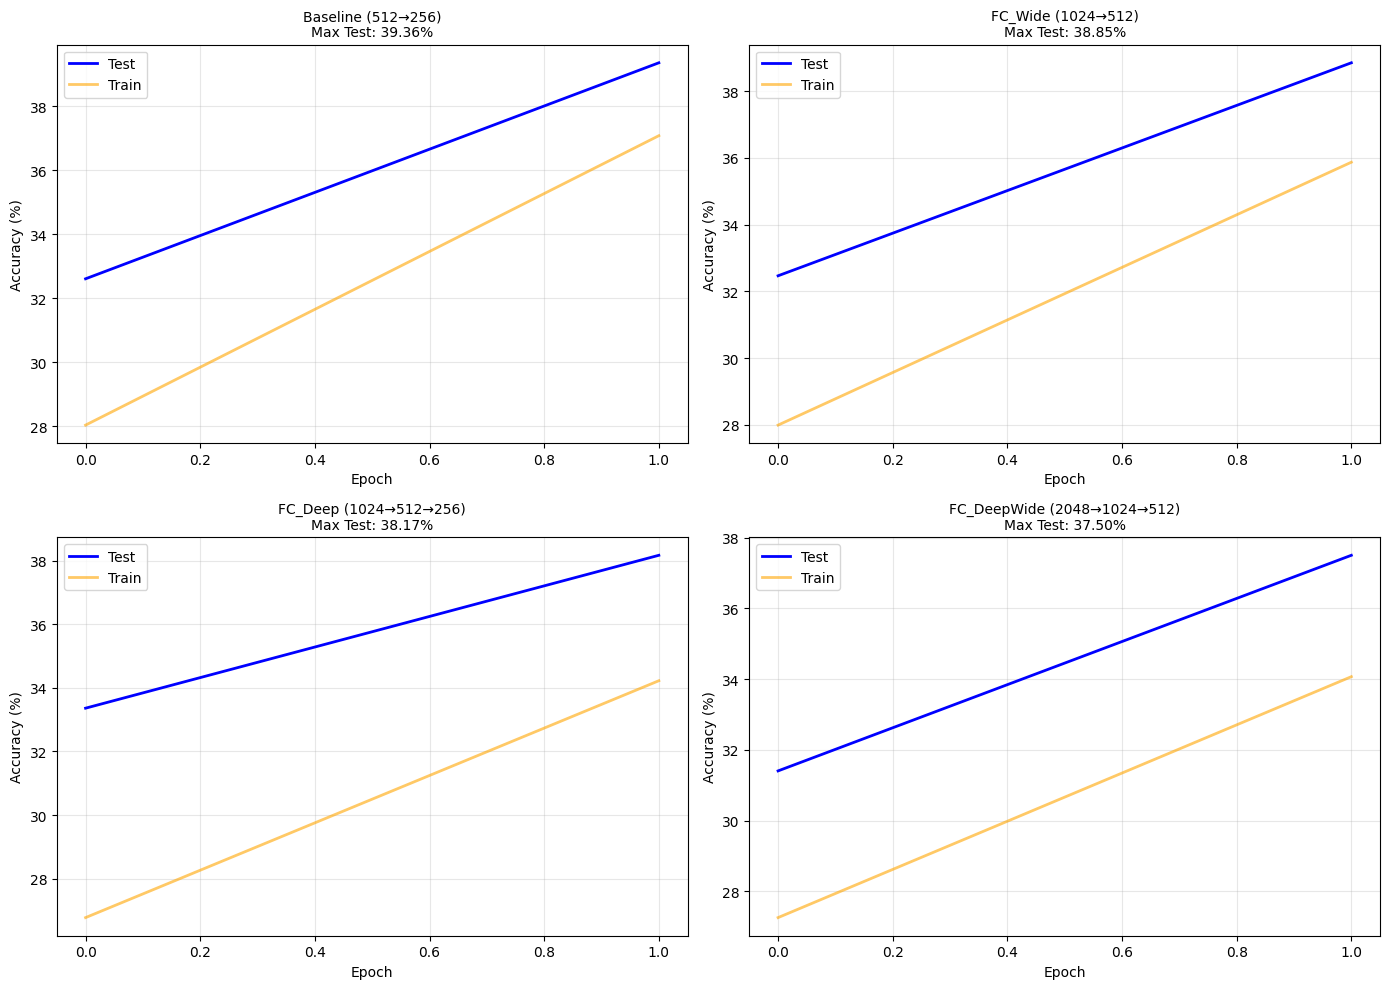

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, name in enumerate(df_stage1['Модель'].tolist()):
    data = results_stage1[name]
    axes[idx].plot(data['test_accs'], label='Test', linewidth=2, color='blue')
    axes[idx].plot(data['train_accs'], label='Train', linewidth=2, color='orange', alpha=0.6)
    axes[idx].set_title(f'{name}\nMax Test: {data["max_test_acc"]:.2f}%', fontsize=10)
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel('Accuracy (%)')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Этап 2: Топ-2 на 2 эпох + Conv 2× варианты

Берем топ-2 из Этапа 1 и обучаем:  
1. С базовым Conv (32→512) на 4 эпохи  
2. С увеличенным Conv 2× (64→1024) на 4 эпохи

In [12]:
# Определяем топ-2 модели из Этапа 1
top2_names = df_stage1['Модель'].tolist()[:2]
print(f'Топ-2 модели: {top2_names}')

Топ-2 модели: ['Baseline (512→256)', 'FC_Wide (1024→512)']


In [13]:
# Создаем Conv 2× варианты для топ-2

# FC_Wide с Conv 2×
class FC_Wide_Conv2x(nn.Module):
    def __init__(self, num_classes=9):
        super(FC_Wide_Conv2x, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(1024 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        
        x = x.view(-1, 1024 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# FC_Deep с Conv 2×
class FC_Deep_Conv2x(nn.Module):
    def __init__(self, num_classes=9):
        super(FC_Deep_Conv2x, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(1024 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, num_classes)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        
        x = x.view(-1, 1024 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

# FC_DeepWide с Conv 2×
class FC_DeepWide_Conv2x(nn.Module):
    def __init__(self, num_classes=9):
        super(FC_DeepWide_Conv2x, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(1024 * 4 * 4, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, num_classes)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = self.pool(self.relu(self.bn5(self.conv5(x))))
        
        x = x.view(-1, 1024 * 4 * 4)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

In [14]:
# Обучение топ-2 моделей на 7 эпох (Conv базовый + Conv 2×)
# ВНИМАНИЕ: Запускайте этот блок только после анализа результатов Этапа 1!
# Замените модели ниже на топ-2 из df_stage1

models_stage2 = [
    # Пример (замените на ваши топ-2):
    (FC_Deep(num_classes=9).to(device), 'FC_Deep (Conv 1x, 4 эпох)'),
    (FC_Deep_Conv2x(num_classes=9).to(device), 'FC_Deep (Conv 2x, 4 эпох)'),
    (FC_DeepWide(num_classes=9).to(device), 'FC_DeepWide (Conv 1x, 4 эпох)'),
    (FC_DeepWide_Conv2x(num_classes=9).to(device), 'FC_DeepWide (Conv 2x, 4 эпох)')
]

results_stage2 = {}
num_epochs_stage2 = 4

for model, name in models_stage2:
    print(f'\nОбучение {name} (7 эпох на augmented_x7)')
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    
    for epoch in range(num_epochs_stage2):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        model.eval()
        test_running_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        
        test_loss = test_running_loss / len(test_loader)
        test_acc = 100 * test_correct / test_total
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        if (epoch + 1) % 2 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs_stage2}] Train Acc: {epoch_acc:.2f}%, Test Acc: {test_acc:.2f}%')
    
    results_stage2[name] = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'max_test_acc': max(test_accs),
        'max_test_epoch': test_accs.index(max(test_accs)) + 1,
        'final_test_acc': test_accs[-1],
        'final_train_acc': train_accs[-1]
    }
    
    print(f'Max Test Acc = {max(test_accs):.2f}% (Epoch {test_accs.index(max(test_accs))+1})')
    
    del model, criterion, optimizer
    gc.collect()
    if device.type == 'mps':
        torch.mps.empty_cache()


Обучение FC_Deep (Conv 1x, 4 эпох) (7 эпох на augmented_x7)
Epoch [2/4] Train Acc: 32.99%, Test Acc: 35.95%
Epoch [4/4] Train Acc: 42.24%, Test Acc: 43.65%
Max Test Acc = 43.65% (Epoch 4)

Обучение FC_Deep (Conv 2x, 4 эпох) (7 эпох на augmented_x7)
Epoch [2/4] Train Acc: 31.06%, Test Acc: 35.47%
Epoch [4/4] Train Acc: 38.75%, Test Acc: 39.94%
Max Test Acc = 39.94% (Epoch 4)

Обучение FC_DeepWide (Conv 1x, 4 эпох) (7 эпох на augmented_x7)


KeyboardInterrupt: 

In [ ]:
results_table_stage2 = []
for name, data in results_stage2.items():
    gap = data['final_train_acc'] - data['final_test_acc']
    results_table_stage2.append({
        'Модель': name,
        'Max Test Acc': data['max_test_acc'],
        'Epoch': data['max_test_epoch'],
        'Final Test Acc': data['final_test_acc'],
        'Gap': gap
    })

df_stage2 = pd.DataFrame(results_table_stage2)
df_stage2 = df_stage2.sort_values('Max Test Acc', ascending=False)
print('\nРезультаты Этапа 2 (4 эпох на augmented_x7)')
print(df_stage2.to_string(index=False))

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, name in enumerate(df_stage2['Модель'].tolist()):
    data = results_stage2[name]
    axes[idx].plot(data['test_accs'], label='Test', linewidth=2, color='blue')
    axes[idx].plot(data['train_accs'], label='Train', linewidth=2, color='orange', alpha=0.6)
    axes[idx].set_title(f'{name}\nMax Test: {data["max_test_acc"]:.2f}%', fontsize=10)
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel('Accuracy (%)')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Финальные результаты

In [ ]:
print('РАВНЕНИЕ ВСЕХ МОДЕЛЕЙ\n')
print(f'Baseline (2 эпохи на augmented_x7): {max(test_accs_baseline):.2f}%')
print('\nЭтап 1 (2 эпохи на augmented_x7):')
print(df_stage1[['Модель', 'Max Test Acc']].to_string(index=False))
print('\nЭтап 2 (4 эпох на augmented_x7):')
print(df_stage2[['Модель', 'Max Test Acc']].to_string(index=False))

РАВНЕНИЕ ВСЕХ МОДЕЛЕЙ

Baseline (2 эпохи на augmented_x7): 33.95%

Этап 1 (2 эпохи на augmented_x7):


NameError: name 'df_stage1' is not defined